In [21]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import geopandas as gpd

from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points

import matplotlib.pyplot as plt


In [22]:
%load_ext kedro.ipython

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


In [23]:
catalog.list()


[
    'incidents',
    'firestations',
    'firestation_areas',
    'census',
    'property_assessments',
    'combined_incidents',
    'preprocessed_incidents',
    'preprocessed_firestations',
    'preprocessed_firestation_areas',
    'preprocessed_property_assessments',
    'enhanced_incidents',
    'parameters'
]

In [24]:
df_fires = catalog.load("enhanced_incidents")
df_fires.head()

[06/26/24 13:44:22] INFO     Loading data from enhanced_incidents (CSVDataset)...               ]8;id=983493;file://C:\Users\carga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=628413;file://C:\Users\carga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\kedro\io\data_catalog.py#508\508]8;;\

,FIRE_STATION_ID,CREATION_DATE,INCIDENT_CATEGORY,AREA_ID,INCIDENT_NBR,INCIDENT_TYPE,LATITUDE,LONGITUDE,UNITS,AREA,INCIDENT_ID,CREATION_TIME,is_fire,day_of_week,month
0,18,2005-01-01,Sans incendie,21,1,Inondation,45.620274,-73.619956,1,Montréal-Nord,0,00:03:47,False,5,1
1,10,2005-01-01,Alarmes-incendies,18,2,Alarme privé ou locale,45.494087,-73.582587,7,Ville-Marie / Parc Jean-Drapeau / Centre-Sud,1,00:03:56,False,5,1
2,72,2005-01-01,Alarmes-incendies,13,3,Alarme privé ou locale,45.484406,-73.693038,6,St-Laurent,2,00:03:57,False,5,1
3,13,2005-01-01,Sans incendie,23,4,Inondation,45.541383,-73.545944,1,Mercier / Hochelaga-Maisonneuve,3,00:05:01,False,5,1
4,18,2005-01-01,Sans incendie,21,5,Inondation,45.611304,-73.632440,1,Montréal-Nord,4,00:06:20,False,5,1


In [25]:
df_areas = catalog.load('preprocessed_firestation_areas')
df_areas.head()

[06/26/24 13:44:30] INFO     Loading data from preprocessed_firestation_areas                   ]8;id=980598;file://C:\Users\carga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=485935;file://C:\Users\carga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\kedro\io\data_catalog.py#508\508]8;;\
                             (GeoJSONDataset)...                                                                   

,FIRE_STATION_ID,geometry
0,72,"POLYGON ((-73.71849 45.52474, -73.71849 45.524..."
1,71,"POLYGON ((-73.73490 45.50978, -73.73490 45.509..."
2,32,"POLYGON ((-73.47494 45.70244, -73.47524 45.702..."
3,25,"POLYGON ((-73.58662 45.51555, -73.58244 45.513..."
4,31,"POLYGON ((-73.60336 45.52838, -73.60459 45.528..."


In [26]:
# Function to create square mesh
def create_square_mesh(geodf, square_size):
    # Get the bounding box of the entire area
    minx, miny, maxx, maxy = geodf.total_bounds

    # Create a grid of points covering the bounding box
    x_coords = np.arange(minx, maxx, square_size)
    y_coords = np.arange(miny, maxy, square_size)
    grid_points = [Point(x, y) for x in x_coords for y in y_coords]

    # Create square polygons from the grid points
    squares = []
    for point in grid_points:
        x, y = point.x, point.y
        square = Polygon([(x, y), (x + square_size, y), (x + square_size, y + square_size), (x, y + square_size)])
        squares.append(square)

    # Create a GeoDataFrame for the squares
    squares_gdf = gpd.GeoDataFrame({'geometry': squares})

    # Clip the squares to the polygon boundaries
    clipped_squares_gdf = gpd.overlay(squares_gdf, geodf, how='intersection')

    return clipped_squares_gdf, squares_gdf

# Load example polygons into a GeoDataFrame
gdf_areas = gpd.GeoDataFrame(df_areas['geometry'])

# Create a square mesh with a given square size from the area cover by the fire department
square_size = 0.01
mesh_gdf, squares_gdf= create_square_mesh(gdf_areas, square_size)


[06/26/24 13:44:32] WARNING  C:\Users\carga\AppData\Local\Temp\ipykernel_23100\391867867.py:22:     warnings.py:109
                             UserWarning: CRS mismatch between the CRS of left geometries and the                  
                             CRS of right geometries.                                                              
                             Use `to_crs()` to reproject one of the input geometries to match the                  
                             CRS of the other.                                                                     
                                                                                                                   
                             Left CRS: None                                                                        
                             Right CRS: EPSG:4326                                                                  
                                                                                                                   
                               clipped_squares_gdf = gpd.overlay(squares_gdf, geodf,                               
                             how='intersection')                                                                   
                                                                                                                   

In [50]:
mesh_gdf.head()

,geometry
0,"MULTIPOLYGON (((-73.96639 45.42215, -73.96639 ..."
1,"MULTIPOLYGON (((-73.96639 45.43215, -73.96639 ..."
2,"POLYGON ((-73.96639 45.43215, -73.97386 45.432..."
3,"POLYGON ((-73.96816 45.44215, -73.96814 45.442..."
4,"MULTIPOLYGON (((-73.95639 45.40404, -73.95674 ..."


In [51]:
mesh_gdf.describe()

,geometry
count,1256
unique,1256
top,MULTIPOLYGON (((-73.96639396315959 45.42214898...
freq,1


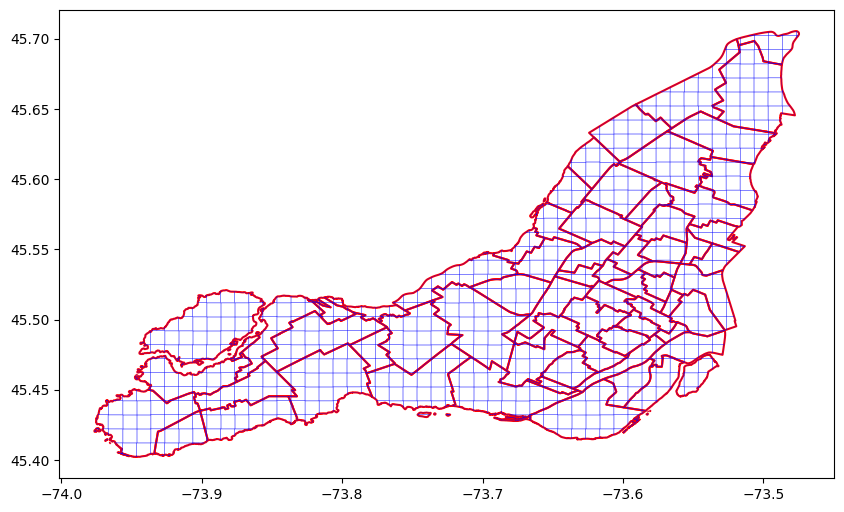

In [27]:
# Plot the result
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_areas.boundary.plot(ax=ax, color='red')
mesh_gdf.boundary.plot(ax=ax, color='blue', linewidth=0.2)
plt.show()

In [28]:
fire_stations = catalog.load("preprocessed_firestations")
fire_stations.head()

[06/26/24 13:44:35] INFO     Loading data from preprocessed_firestations (CSVDataset)...        ]8;id=201636;file://C:\Users\carga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=95526;file://C:\Users\carga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\kedro\io\data_catalog.py#508\508]8;;\

,FIRE_STATION_ID,STREET_NUMBER,STREET_NAME,LATITUDE,LONGITUDE,START_DATE,END_DATE,AREA
0,3,256,rue Young,45.493454,-73.560172,2015-01-01,NaT,LE SUD-OUEST
1,15,1255,rue de la Sucrerie,45.484419,-73.560917,2015-01-01,NaT,LE SUD-OUEST
2,23,523,place Saint-Henri,45.477820,-73.585257,2015-01-01,NaT,LE SUD-OUEST
3,33,6040,boulevard Monk,45.457841,-73.595450,2015-01-01,NaT,LE SUD-OUEST
4,9,8100,boulevard Saint-Michel,45.563748,-73.610169,2019-05-06,NaT,VILLERAY-SAINT-MICHEL-PARC-EXTENSION


In [29]:
features = ['FIRE_STATION_ID', 'LATITUDE', 'LONGITUDE', 'START_DATE', 'END_DATE']
fire_stations = fire_stations[features]

In [30]:
land_use = catalog.load("preprocessed_property_assessments")
land_use.head()

[06/26/24 13:44:40] INFO     Loading data from preprocessed_property_assessments                ]8;id=696104;file://C:\Users\carga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=65489;file://C:\Users\carga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\kedro\io\data_catalog.py#508\508]8;;\
                             (CSVDataset)...                                                                       

,ASSESSMENT_ID,MUNICIPALITE,ABOVE_GROUND_FLOORS,HOUSING_UNITS,YEAR_CONSTRUCTION,USE_CODE,USE_DESCRIPTION,USE_CATEGORY,AREA_LAND,AREA_BUILDING,LATITUDE,LONGITUDE
0,1049937,50,3.0,6.0,1928,1000,Logement,Régulier,348,457.0,45.455506,-73.575097
1,1007083,50,3.0,4.0,1965,1000,Logement,Régulier,189,321.0,45.460041,-73.593359
2,1008256,29,2.0,2.0,1927,1000,Logement,Régulier,311,311.0,45.486017,-73.599385
3,4039931,50,1.0,1.0,1975,1000,Logement,Régulier,383,119.0,45.434633,-73.612644
4,4043326,50,2.0,2.0,1966,1000,Logement,Régulier,220,209.0,45.429886,-73.629457


In [ ]:
# Generate synthetic fire station data
fire_stations = pd.DataFrame({
    'LATITUDE': np.random.uniform(45.4, 45.7, 10),
    'LONGITUDE': np.random.uniform(-73.9, -73.5, 10)
})

# Generate synthetic land use data
land_use = pd.DataFrame({
    'LATITUDE': np.random.uniform(45.4, 45.7, 50000),
    'LONGITUDE': np.random.uniform(-73.9, -73.5, 50000),
    'land_use_type': np.random.choice(['residential', 'commercial', 'industrial', 'park'], 50000)
})

In [31]:
# Generate synthetic weather data
periods = 7000

weather_data = pd.DataFrame({
    'date': pd.date_range(start='2005-01-01', periods=periods, freq='D'),
    'max_temp': np.random.uniform(-10, 30, periods),
    'min_temp': np.random.uniform(-15, 25, periods),
    'precipitation': np.random.uniform(0, 20, periods),
    'wind_speed': np.random.uniform(0, 15, periods)
})

In [32]:
# Convert to GeoDataFrames
fire_stations['geometry'] = [Point(xy) for xy in zip(fire_stations.LONGITUDE, fire_stations.LATITUDE)]
fire_stations_gdf = gpd.GeoDataFrame(fire_stations, geometry='geometry')

land_use['geometry'] = [Point(xy) for xy in zip(land_use.LONGITUDE, land_use.LATITUDE)]
land_use_gdf = gpd.GeoDataFrame(land_use, geometry='geometry')


In [33]:
# Ensure datetime conversion and clean data
df_fires['CREATION_DATE'] = pd.to_datetime(df_fires['CREATION_DATE'], errors='coerce')
df_fires = df_fires.dropna(subset=['CREATION_DATE'])
df_fires['date'] = df_fires['CREATION_DATE'].dt.date
weather_data['date'] = pd.to_datetime(weather_data['date']).dt.date

In [34]:
# Merge fire data with weather data
df_fires = pd.merge(df_fires, weather_data, on='date', how='left')

df_fires.head()

,FIRE_STATION_ID,CREATION_DATE,INCIDENT_CATEGORY,AREA_ID,INCIDENT_NBR,INCIDENT_TYPE,LATITUDE,LONGITUDE,UNITS,AREA,INCIDENT_ID,CREATION_TIME,is_fire,day_of_week,month,date,max_temp,min_temp,precipitation,wind_speed
0,18,2005-01-01,Sans incendie,21,1,Inondation,45.620274,-73.619956,1,Montréal-Nord,0,00:03:47,False,5,1,2005-01-01,28.228108,16.823162,14.743374,7.993012
1,10,2005-01-01,Alarmes-incendies,18,2,Alarme privé ou locale,45.494087,-73.582587,7,Ville-Marie / Parc Jean-Drapeau / Centre-Sud,1,00:03:56,False,5,1,2005-01-01,28.228108,16.823162,14.743374,7.993012
2,72,2005-01-01,Alarmes-incendies,13,3,Alarme privé ou locale,45.484406,-73.693038,6,St-Laurent,2,00:03:57,False,5,1,2005-01-01,28.228108,16.823162,14.743374,7.993012
3,13,2005-01-01,Sans incendie,23,4,Inondation,45.541383,-73.545944,1,Mercier / Hochelaga-Maisonneuve,3,00:05:01,False,5,1,2005-01-01,28.228108,16.823162,14.743374,7.993012
4,18,2005-01-01,Sans incendie,21,5,Inondation,45.611304,-73.632440,1,Montréal-Nord,4,00:06:20,False,5,1,2005-01-01,28.228108,16.823162,14.743374,7.993012


In [35]:
# Convert to GeoDataFrames
fire_data_gdf = gpd.GeoDataFrame(df_fires, geometry=gpd.points_from_xy(df_fires.LONGITUDE, df_fires.LATITUDE))

In [22]:
# Calculate proximity to nearest fire station
nearest_station = fire_data_gdf.geometry.apply(lambda x: nearest_points(x, fire_stations_gdf.unary_union)[1])
fire_data_gdf['distance_to_station'] = fire_data_gdf.geometry.distance(nearest_station)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 # Calculate proximity to nearest fire station                                                │
│ ❱ 2 nearest_station = fire_data_gdf.geometry.apply(lambda x: nearest_points(x, fire_stations     │
│   3 fire_data_gdf['distance_to_station'] = fire_data_gdf.geometry.distance(nearest_station)      │
│   4                                                                                              │
│                                                                                                  │
│ C:\Users\carga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCac │
│ he\local-packages\Python38\site-packages\geopandas\geoseries.py:645 in apply                     │
│                                                                                                  │
│    642 │                                                                                         │
│    643 │   @doc(pd.Series)                                                                       │
│    644 │   def apply(self, func, convert_dtype=True, args=(), **kwargs):                         │
│ ❱  645 │   │   result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)    │
│    646 │   │   if isinstance(result, GeoSeries):                                                 │
│    647 │   │   │   if self.crs is not None:                                                      │
│    648 │   │   │   │   result.set_crs(self.crs, inplace=True)                                    │
│                                                                                                  │
│ C:\Users\carga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCac │
│ he\local-packages\Python38\site-packages\pandas\core\series.py:4630 in apply                     │
│                                                                                                  │
│   4627 │   │   Helsinki    2.484907                                                              │
│   4628 │   │   dtype: float64                                                                    │
│   4629 │   │   """                                                                               │
│ ❱ 4630 │   │   return SeriesApply(self, func, convert_dtype, args, kwargs).apply()               │
│   4631 │                                                                                         │
│   4632 │   def _reduce(                                                                          │
│   4633 │   │   self,                                                                             │
│                                                                                                  │
│ C:\Users\carga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCac │
│ he\local-packages\Python38\site-packages\pandas\core\apply.py:1025 in apply                      │
│                                                                                                  │
│   1022 │   │   │   return self.apply_str()                                                       │
│   1023 │   │                                                                                     │
│   1024 │   │   # self.f is Callable                                                              │
│ ❱ 1025 │   │   return self.apply_standard()                                                      │
│   1026 │                                                                                         │
│   1027 │   def agg(self):                                                                        │
│   1028 │   │   result = super().agg()                      

In [36]:
fire_data_gdf.head()

,FIRE_STATION_ID,CREATION_DATE,INCIDENT_CATEGORY,AREA_ID,INCIDENT_NBR,INCIDENT_TYPE,LATITUDE,LONGITUDE,UNITS,AREA,...,CREATION_TIME,is_fire,day_of_week,month,date,max_temp,min_temp,precipitation,wind_speed,geometry
0,18,2005-01-01,Sans incendie,21,1,Inondation,45.620274,-73.619956,1,Montréal-Nord,...,00:03:47,False,5,1,2005-01-01,28.228108,16.823162,14.743374,7.993012,POINT (-73.61996 45.62027)
1,10,2005-01-01,Alarmes-incendies,18,2,Alarme privé ou locale,45.494087,-73.582587,7,Ville-Marie / Parc Jean-Drapeau / Centre-Sud,...,00:03:56,False,5,1,2005-01-01,28.228108,16.823162,14.743374,7.993012,POINT (-73.58259 45.49409)
2,72,2005-01-01,Alarmes-incendies,13,3,Alarme privé ou locale,45.484406,-73.693038,6,St-Laurent,...,00:03:57,False,5,1,2005-01-01,28.228108,16.823162,14.743374,7.993012,POINT (-73.69304 45.48441)
3,13,2005-01-01,Sans incendie,23,4,Inondation,45.541383,-73.545944,1,Mercier / Hochelaga-Maisonneuve,...,00:05:01,False,5,1,2005-01-01,28.228108,16.823162,14.743374,7.993012,POINT (-73.54594 45.54138)
4,18,2005-01-01,Sans incendie,21,5,Inondation,45.611304,-73.632440,1,Montréal-Nord,...,00:06:20,False,5,1,2005-01-01,28.228108,16.823162,14.743374,7.993012,POINT (-73.63244 45.61130)


In [37]:
fire_data_gdf.columns


Index(['FIRE_STATION_ID', 'CREATION_DATE', 'INCIDENT_CATEGORY', 'AREA_ID',
       'INCIDENT_NBR', 'INCIDENT_TYPE', 'LATITUDE', 'LONGITUDE', 'UNITS',
       'AREA', 'INCIDENT_ID', 'CREATION_TIME', 'is_fire', 'day_of_week',
       'month', 'date', 'max_temp', 'min_temp', 'precipitation', 'wind_speed',
       'geometry'],
      dtype='object')

In [38]:
land_use_gdf.head()

,ASSESSMENT_ID,MUNICIPALITE,ABOVE_GROUND_FLOORS,HOUSING_UNITS,YEAR_CONSTRUCTION,USE_CODE,USE_DESCRIPTION,USE_CATEGORY,AREA_LAND,AREA_BUILDING,LATITUDE,LONGITUDE,geometry
0,1049937,50,3.0,6.0,1928,1000,Logement,Régulier,348,457.0,45.455506,-73.575097,POINT (-73.57510 45.45551)
1,1007083,50,3.0,4.0,1965,1000,Logement,Régulier,189,321.0,45.460041,-73.593359,POINT (-73.59336 45.46004)
2,1008256,29,2.0,2.0,1927,1000,Logement,Régulier,311,311.0,45.486017,-73.599385,POINT (-73.59938 45.48602)
3,4039931,50,1.0,1.0,1975,1000,Logement,Régulier,383,119.0,45.434633,-73.612644,POINT (-73.61264 45.43463)
4,4043326,50,2.0,2.0,1966,1000,Logement,Régulier,220,209.0,45.429886,-73.629457,POINT (-73.62946 45.42989)


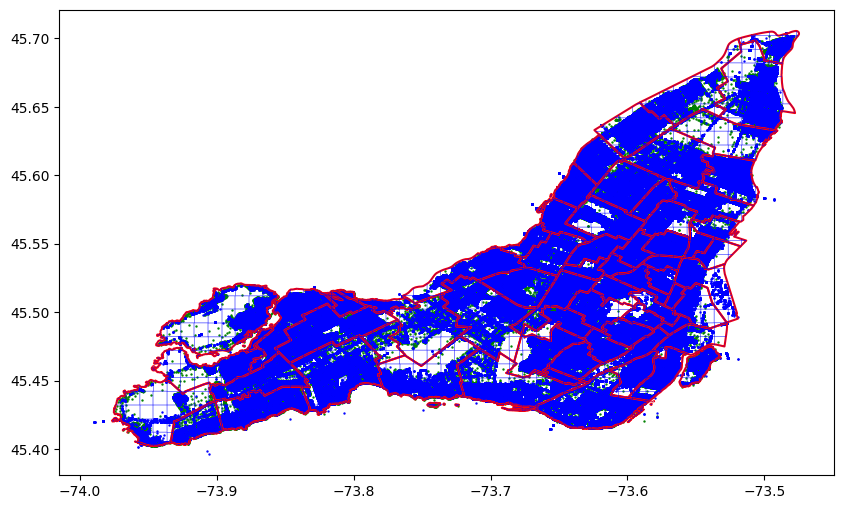

In [39]:
# Plot the result
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_areas.boundary.plot(ax=ax, color='red')
mesh_gdf.boundary.plot(ax=ax, color='blue', linewidth=0.2)
land_use_gdf.plot(ax=ax, color='green', markersize=0.5)
fire_data_gdf.plot(ax=ax, color='blue', markersize=0.5, marker='o')
plt.show()

In [18]:
# Include fire incidents data
fire_data_gdf = gpd.sjoin(fire_data_gdf, land_use_gdf[['geometry', 'ABOVE_GROUND_FLOORS', 'HOUSING_UNITS', 'YEAR_CONSTRUCTION', 'USE_CODE', 'USE_DESCRIPTION', 'USE_CATEGORY', 'AREA_LAND', 'AREA_BUILDING']], how='left', op='intersects')

[06/26/24 07:43:40] WARNING  C:\Users\carga\AppData\Local\Packages\PythonSoftwareFoundation.Python. warnings.py:109
                             3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\IPy                
                             thon\core\interactiveshell.py:3448: FutureWarning: The `op` parameter                 
                             is deprecated and will be removed in a future release. Please use the                 
                             `predicate` parameter instead.                                                        
                               if await self.run_code(code, result, async_=asy):                                   
                                                                                                                   

In [ ]:
# Aggregate fire incident counts by grid and temporal features
fire_data_gdf['grid_lat'] = np.floor(fire_data_gdf['LATITUDE'] / square_size) * square_size
fire_data_gdf['grid_long'] = np.floor(fire_data_gdf['LONGITUDE'] / square_size) * square_size
fire_data_gdf['day_of_week'] = fire_data_gdf['CREATION_DATE'].dt.dayofweek
fire_data_gdf['month'] = fire_data_gdf['CREATION_DATE'].dt.month

group_columns = ['grid_lat', 'grid_long', 'day_of_week', 'month']
grid_fire_counts = fire_data_gdf.groupby(group_columns).size().reset_index(name='count')

# Merge additional features
enhanced_features = fire_data_gdf[['grid_lat', 'grid_long', 'day_of_week', 'month',
                                   'max_temp', 'precipitation', 'distance_to_station', 'land_use_type']].drop_duplicates()
enhanced_fire_data = pd.merge(grid_fire_counts, enhanced_features, on=['grid_lat', 'grid_long', 'day_of_week', 'month'], how='left')

# Aggregate historical fire frequency by grid cell
#historical_frequency = fire_data_gdf.groupby(['grid_lat', 'grid_long']).size().reset_index(name='historical_frequency')
#enhanced_fire_data = pd.merge(enhanced_fire_data, historical_frequency, on=['grid_lat', 'grid_long'], how='left')

In [42]:
print(mesh_gdf.columns)

Index(['geometry'], dtype='object')


In [43]:
# Spatial join points with the grid
fire_data_gdf_joined = gpd.sjoin(fire_data_gdf, mesh_gdf, how='inner', predicate='intersects', rsuffix='mesh')
land_use_gdf_joined = gpd.sjoin(land_use_gdf, mesh_gdf, how='inner', predicate='intersects', rsuffix='mesh')

In [517]:
land_use_gdf_joined.head()

,ID,MUNICIPALITE,ABOVE_GROUND_FLOORS,HOUSING_UNITS,YEAR_CONSTRUCTION,USE_CODE,USE_DESCRIPTION,USE_CATEGORY,AREA_LAND,AREA_BUILDING,LATITUDE,LONGITUDE,geometry,land_ID,index_mesh
0,1049937,50,3.0,6.0,1928,1000,Logement,Régulier,348,457.0,45.455506,-73.575097,POINT (-73.57510 45.45551),0,897
14,1047664,50,2.0,3.0,1948,1000,Logement,Régulier,453,250.0,45.460724,-73.575146,POINT (-73.57515 45.46072),14,897
18,1050078,50,2.0,2.0,1949,1000,Logement,Régulier,119,208.0,45.453014,-73.567697,POINT (-73.56770 45.45301),18,897
533,1049007,50,3.0,6.0,1925,1000,Logement,Régulier,261,324.0,45.457636,-73.566582,POINT (-73.56658 45.45764),533,897
763,1050441,50,2.0,6.0,1940,1000,Logement,Régulier,300,219.0,45.453521,-73.569936,POINT (-73.56994 45.45352),763,897


In [509]:
land_use_gdf_joined.describe()

,ID,MUNICIPALITE,ABOVE_GROUND_FLOORS,HOUSING_UNITS,YEAR_CONSTRUCTION,USE_CODE,AREA_LAND,AREA_BUILDING,LATITUDE,LONGITUDE,land_ID,index_right
count,5.086550e+05,508655.000000,458051.000000,461652.000000,508655.000000,508655.000000,5.086550e+05,473144.000000,508655.000000,508655.000000,508655.000000,508655.000000
mean,3.522742e+06,44.087543,1.681769,2.213756,2324.781966,1417.326656,7.902437e+02,293.189348,45.520620,-73.637859,254349.072287,716.230742
std,1.462795e+06,14.358708,0.824212,9.750717,1649.918991,1541.980957,1.721335e+04,2130.578327,0.059853,0.099692,146854.273643,317.668873
min,1.000002e+06,2.000000,1.000000,1.000000,1600.000000,1000.000000,0.000000e+00,0.000000,45.402264,-73.974446,0.000000,0.000000
25%,2.083610e+06,50.000000,1.000000,1.000000,1952.000000,1000.000000,6.700000e+01,95.000000,45.475880,-73.670947,127168.500000,478.000000
50%,4.012688e+06,50.000000,2.000000,1.000000,1973.000000,1000.000000,2.370000e+02,147.000000,45.513091,-73.608218,254347.000000,749.000000
75%,5.101664e+06,50.000000,2.000000,2.000000,2004.000000,1000.000000,4.460000e+02,226.000000,45.554278,-73.568706,381520.500000,971.000000
max,5.305110e+06,50.000000,47.000000,3100.000000,9999.000000,9900.000000,5.424280e+06,947140.000000,45.702132,-73.477882,508712.000000,1252.000000


In [46]:
duplicates_fire = fire_data_gdf_joined[fire_data_gdf_joined.duplicated(subset=['INCIDENT_ID'], keep='first')]
duplicates_land = land_use_gdf_joined[land_use_gdf_joined.duplicated(subset=['ASSESSMENT_ID'], keep='first')]

print(duplicates_fire)
print(duplicates_land)

Empty GeoDataFrame
Columns: [FIRE_STATION_ID, CREATION_DATE, INCIDENT_CATEGORY, AREA_ID, INCIDENT_NBR, INCIDENT_TYPE, LATITUDE, LONGITUDE, UNITS, AREA, INCIDENT_ID, CREATION_TIME, is_fire, day_of_week, month, date, max_temp, min_temp, precipitation, wind_speed, geometry, index_mesh]
Index: []

[0 rows x 22 columns]
Empty GeoDataFrame
Columns: [ASSESSMENT_ID, MUNICIPALITE, ABOVE_GROUND_FLOORS, HOUSING_UNITS, YEAR_CONSTRUCTION, USE_CODE, USE_DESCRIPTION, USE_CATEGORY, AREA_LAND, AREA_BUILDING, LATITUDE, LONGITUDE, geometry, index_mesh]
Index: []


In [47]:
# Remove duplicates
fire_data_gdf_joined.drop_duplicates(subset=['INCIDENT_ID'], keep='first', inplace=True)
land_use_gdf_joined.drop_duplicates(subset=['ASSESSMENT_ID'], keep='first', inplace=True)

In [48]:
# You can merge or join these based on the grid cell geometry
gdf_joined = fire_data_gdf_joined.merge(land_use_gdf_joined, how='outer', suffixes=('_incidents', '_assessment'))

In [513]:
gdf_joined.describe()

,FIRE_STATION_ID,CREATION_DATE,AREA_ID,INCIDENT_NBR,LATITUDE,LONGITUDE,UNITS,day_of_week,month,incident_ID,index_right,ID,MUNICIPALITE,ABOVE_GROUND_FLOORS,HOUSING_UNITS,YEAR_CONSTRUCTION,USE_CODE,AREA_LAND,AREA_BUILDING,land_ID
count,1.922726e+06,1922726,1.922726e+06,1.922726e+06,2.431381e+06,2.431381e+06,1.922726e+06,1.922726e+06,1.922726e+06,1.922726e+06,2.431381e+06,5.086550e+05,508655.000000,458051.000000,461652.000000,508655.000000,508655.000000,5.086550e+05,473144.000000,508655.000000
mean,3.819830e+01,2015-05-09 19:48:08.180635648,7.903113e+00,5.710388e+04,4.552448e+01,-7.362708e+01,1.961628e+00,2.991628e+00,6.605530e+00,9.620513e+05,7.440768e+02,3.522742e+06,44.087543,1.681769,2.213756,2324.781966,1417.326656,7.902437e+02,293.189348,254349.072287
min,0.000000e+00,2005-01-01 00:00:00,0.000000e+00,1.000000e+00,4.540226e+01,-7.397460e+01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000002e+06,2.000000,1.000000,1.000000,1600.000000,1000.000000,0.000000e+00,0.000000,0.000000
25%,2.000000e+01,2011-04-21 00:00:00,4.000000e+00,2.669100e+04,4.548351e+01,-7.365171e+01,1.000000e+00,1.000000e+00,4.000000e+00,4.809552e+05,5.540000e+02,2.083610e+06,50.000000,1.000000,1.000000,1952.000000,1000.000000,6.700000e+01,95.000000,127168.500000
50%,3.700000e+01,2015-06-13 00:00:00,6.000000e+00,5.377000e+04,4.551943e+01,-7.360558e+01,1.000000e+00,3.000000e+00,7.000000e+00,9.619215e+05,7.590000e+02,4.012688e+06,50.000000,2.000000,1.000000,1973.000000,1000.000000,2.370000e+02,147.000000,254347.000000
75%,5.500000e+01,2019-06-16 00:00:00,1.000000e+01,8.618400e+04,4.555929e+01,-7.356932e+01,2.000000e+00,5.000000e+00,1.000000e+01,1.443177e+06,9.700000e+02,5.101664e+06,50.000000,2.000000,2.000000,2004.000000,1000.000000,4.460000e+02,226.000000,381520.500000
max,7.900000e+01,2023-12-31 00:00:00,2.500000e+01,5.001270e+05,4.570249e+01,-7.347788e+01,2.750000e+02,6.000000e+00,1.200000e+01,1.924400e+06,1.252000e+03,5.305110e+06,50.000000,47.000000,3100.000000,9999.000000,9900.000000,5.424280e+06,947140.000000,508712.000000
std,2.065316e+01,NaN,5.787624e+00,3.558678e+04,5.744222e-02,8.832975e-02,2.323149e+00,1.986634e+00,3.440964e+00,5.555104e+05,2.946947e+02,1.462795e+06,14.358708,0.824212,9.750717,1649.918991,1541.980957,1.721335e+04,2130.578327,146854.273643


In [515]:
gdf_joined.head(100)

,FIRE_STATION_ID,CREATION_DATE,INCIDENT_CATEGORY,AREA_ID,INCIDENT_NBR,INCIDENT_TYPE,LATITUDE,LONGITUDE,UNITS,AREA,...,MUNICIPALITE,ABOVE_GROUND_FLOORS,HOUSING_UNITS,YEAR_CONSTRUCTION,USE_CODE,USE_DESCRIPTION,USE_CATEGORY,AREA_LAND,AREA_BUILDING,land_ID
0,18.0,2005-01-01,Sans incendie,21.0,1.0,Inondation,45.620274,-73.619956,1.0,Montréal-Nord,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18.0,2005-01-01,Sans incendie,21.0,11.0,Problèmes électriques,45.620052,-73.616633,1.0,Montréal-Nord,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18.0,2005-08-23,Sans incendie,21.0,32342.0,10-22 sans feu,45.620052,-73.616633,1.0,Montréal-Nord,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18.0,2005-01-01,Sans incendie,21.0,20.0,Inondation,45.621476,-73.623223,1.0,Montréal-Nord,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18.0,2005-04-11,Autres incendies,21.0,12995.0,Déchets en feu,45.621476,-73.623223,1.0,Montréal-Nord,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,18.0,2007-10-22,Sans incendie,21.0,42420.0,Aliments surchauffés,45.619288,-73.625891,4.0,Montréal-Nord,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,18.0,2005-01-12,Sans incendie,21.0,1428.0,Matières dangereuses / 10-22,45.621572,-73.621679,2.0,Montréal-Nord,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,18.0,2006-03-25,Sans incendie,21.0,10724.0,Aide à un citoyen,45.621572,-73.621679,1.0,Montréal-Nord,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,18.0,2005-01-14,Sans incendie,21.0,1654.0,Inondation,45.616604,-73.624200,1.0,Montréal-Nord,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


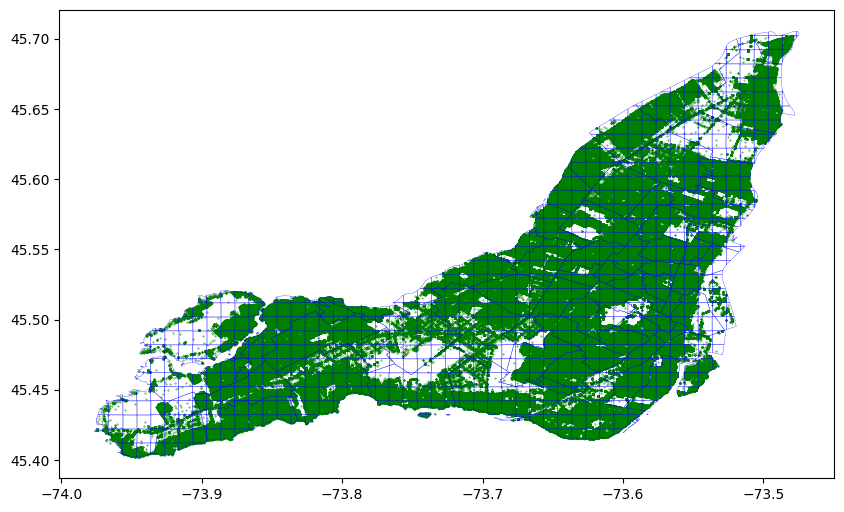

In [49]:
# Plot the result
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
mesh_gdf.boundary.plot(ax=ax, color='blue', linewidth=0.2)
#fire_data_gdf.plot(ax=ax, color='black', markersize=40, marker='x')
#fire_data_gdf_joined.plot(ax=ax, color='red', markersize=0.1, marker='o')
#gdf2.plot(ax=ax, color='black', markersize=40, marker='x')
gdf_joined.plot(ax=ax, color='green', markersize=0.1, marker='o')
plt.show()

In [505]:
# Example GeoDataFrame 1
data1 = {'id': [1, 2, 3, 7, 8],
         'geometry': [Point(-73.5673, 45.5017), Point(-73.5674, 45.5018), Point(-73.5675, 45.5019), Point(-73.56745, 45.50185), Point(-73.5679, 45.5023)]}
gdf1 = gpd.GeoDataFrame(data1, crs="EPSG:4326")

# Example GeoDataFrame 2
data2 = {'id': [4, 5, 6],
         'geometry': [Point(-73.5676, 45.5020), Point(-73.5677, 45.5021), Point(-73.5678, 45.5022)]}
gdf2 = gpd.GeoDataFrame(data2, crs="EPSG:4326")

# Reproject to a suitable CRS for metric measurements
#gdf1 = gdf1.to_crs(epsg=32618)
#gdf2 = gdf2.to_crs(epsg=32618)

# Define the extent of the grid (the bounding box of the island of Montreal)
minx, miny, maxx, maxy = -73.5678, 45.5017, -73.5673, 45.5022

grid_joined = pd.concat([gdf1.geometry, gdf2.geometry], ignore_index=True)

#minx, miny, maxx, maxy = grid_joined.total_bounds
print(minx, miny, maxx, maxy)

# Define the grid size
grid_size = 0.0001

# Create the grid
grid_cells = []
x_start = minx
while x_start < maxx:
    y_start = miny
    while y_start < maxy:
        grid_cells.append(Polygon([(x_start, y_start),
                                   (x_start + grid_size, y_start),
                                   (x_start + grid_size, y_start + grid_size),
                                   (x_start, y_start + grid_size)]))
        y_start += grid_size
    x_start += grid_size

grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'])

# Spatial join points with the grid
gdf1_joined = gpd.sjoin(gdf1, grid, how='inner', predicate='intersects')
#gdf1_joined = gdf1.intersection(grid)
gdf2_joined = gpd.sjoin(gdf2, grid, how='inner', predicate='intersects')
# Remove duplicates
gdf1_joined.drop_duplicates(subset=['id'], keep='first', inplace=True)
gdf2_joined.drop_duplicates(subset=['id'], keep='first', inplace=True)
# Now, gdf1_joined and gdf2_joined contain the grid cell each point falls into
# You can merge or join these based on the grid cell geometry
gdf_joined = gdf1_joined.merge(gdf2_joined, how='outer', suffixes=('_gdf1', '_gdf2'))

-73.5678 45.5017 -73.5673 45.5022


[06/26/24 12:57:31] WARNING  C:\Users\carga\AppData\Local\Temp\ipykernel_1788\625454857.py:42:      warnings.py:109
                             UserWarning: CRS mismatch between the CRS of left geometries and the                  
                             CRS of right geometries.                                                              
                             Use `to_crs()` to reproject one of the input geometries to match the                  
                             CRS of the other.                                                                     
                                                                                                                   
                             Left CRS: EPSG:4326                                                                   
                             Right CRS: None                                                                       
                                                                                                                   
                               gdf1_joined = gpd.sjoin(gdf1, grid, how='inner',                                    
                             predicate='intersects')                                                               
                                                                                                                   

                    WARNING  C:\Users\carga\AppData\Local\Temp\ipykernel_1788\625454857.py:44:      warnings.py:109
                             UserWarning: CRS mismatch between the CRS of left geometries and the                  
                             CRS of right geometries.                                                              
                             Use `to_crs()` to reproject one of the input geometries to match the                  
                             CRS of the other.                                                                     
                                                                                                                   
                             Left CRS: EPSG:4326                                                                   
                             Right CRS: None                                                                       
                                                                                                                   
                               gdf2_joined = gpd.sjoin(gdf2, grid, how='inner',                                    
                             predicate='intersects')                                                               
                                                                                                                   

In [441]:
gdf1_joined.head()

,id,geometry,index_right
0,1,POINT (-73.56730 45.50170),20
1,2,POINT (-73.56740 45.50180),15
2,3,POINT (-73.56750 45.50190),16
3,7,POINT (-73.56745 45.50185),16


In [442]:
gdf2_joined.head()

,id,geometry,index_right
0,4,POINT (-73.56760 45.50200),7
1,5,POINT (-73.56770 45.50210),3
2,6,POINT (-73.56780 45.50220),4


In [443]:
gdf_joined.head(10)

,id,geometry,index_right
0,1,POINT (-73.56730 45.50170),20
1,2,POINT (-73.56740 45.50180),15
2,3,POINT (-73.56750 45.50190),16
3,7,POINT (-73.56745 45.50185),16
4,4,POINT (-73.56760 45.50200),7
5,5,POINT (-73.56770 45.50210),3
6,6,POINT (-73.56780 45.50220),4


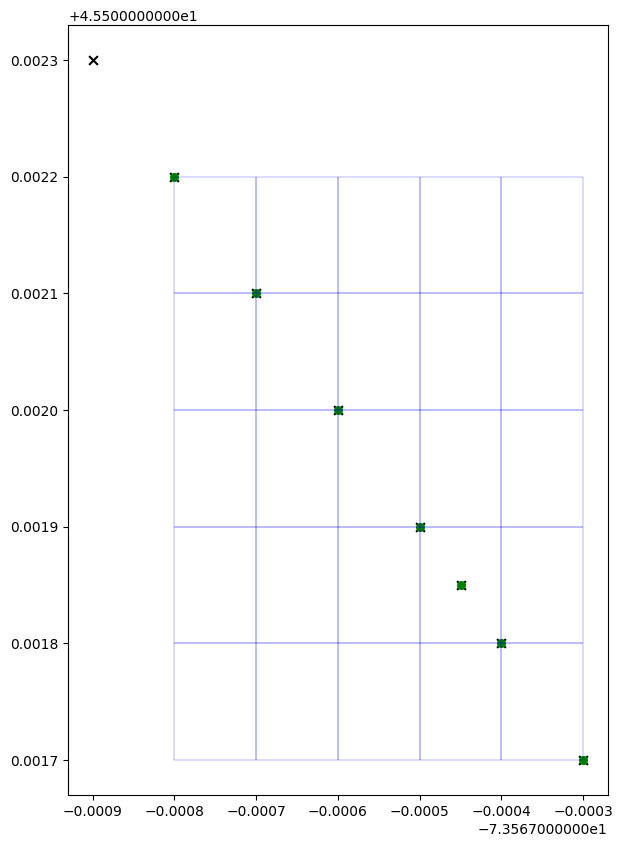

In [444]:
# Plot the result
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
grid.boundary.plot(ax=ax, color='blue', linewidth=0.2)
gdf1.plot(ax=ax, color='black', markersize=40, marker='x')
#gdf1_joined.plot(ax=ax, color='red', markersize=0.1, marker='o')
gdf2.plot(ax=ax, color='black', markersize=40, marker='x')
gdf_joined.plot(ax=ax, color='green', markersize=30, marker='o')
plt.show()

In [ ]:
nan_rows = fire_data_gdf[fire_data_gdf['city'].isna()]

# Display rows with NaN values
print(nan_rows)

In [392]:
# Example GeoDataFrame 1
data1 = {'id': [1, 2, 3, 7],
         'geometry': [Point(-73.5673, 45.5017), Point(-73.5674, 45.5018), Point(-73.5675, 45.5019), Point(-73.56745, 45.50185)]}
gdf1 = gpd.GeoDataFrame(data1, crs="EPSG:4326")

# Example GeoDataFrame 2
data2 = {'id': [4, 5, 6],
         'geometry': [Point(-73.5676, 45.5020), Point(-73.5677, 45.5021), Point(-73.5678, 45.5022)]}
gdf2 = gpd.GeoDataFrame(data2, crs="EPSG:4326")

# Reproject to a suitable CRS for metric measurements
#gdf1 = gdf1.to_crs(epsg=32618)
#gdf2 = gdf2.to_crs(epsg=32618)

# Define the extent of the grid (the bounding box of the island of Montreal)
#minx, miny, maxx, maxy = -73.5679,45.5015,-73.5674,45.5020

grid_joined = pd.concat([gdf1.geometry, gdf2.geometry], ignore_index=True)

# Get the bounding box of the entire area
minx, miny, maxx, maxy = grid_joined.total_bounds

# Define the grid size
square_size = 0.0001

# Create a grid of points covering the bounding box
x_coords = np.arange(minx, maxx, square_size)
y_coords = np.arange(miny, maxy, square_size)
grid_points = [Point(x, y) for x in x_coords for y in y_coords]

# Create square polygons from the grid points
squares = []
for point in grid_points:
    x, y = point.x, point.y
    square = Polygon([(x, y), (x + square_size, y), (x + square_size, y + square_size), (x, y + square_size)])
    squares.append(square)

# Create a GeoDataFrame for the squares
squares_gdf = gpd.GeoDataFrame({'geometry': squares})

In [393]:
squares_gdf.head()

,geometry
0,"POLYGON ((-73.56780 45.50170, -73.56770 45.501..."
1,"POLYGON ((-73.56780 45.50180, -73.56770 45.501..."
2,"POLYGON ((-73.56780 45.50190, -73.56770 45.501..."
3,"POLYGON ((-73.56780 45.50200, -73.56770 45.502..."
4,"POLYGON ((-73.56780 45.50210, -73.56770 45.502..."


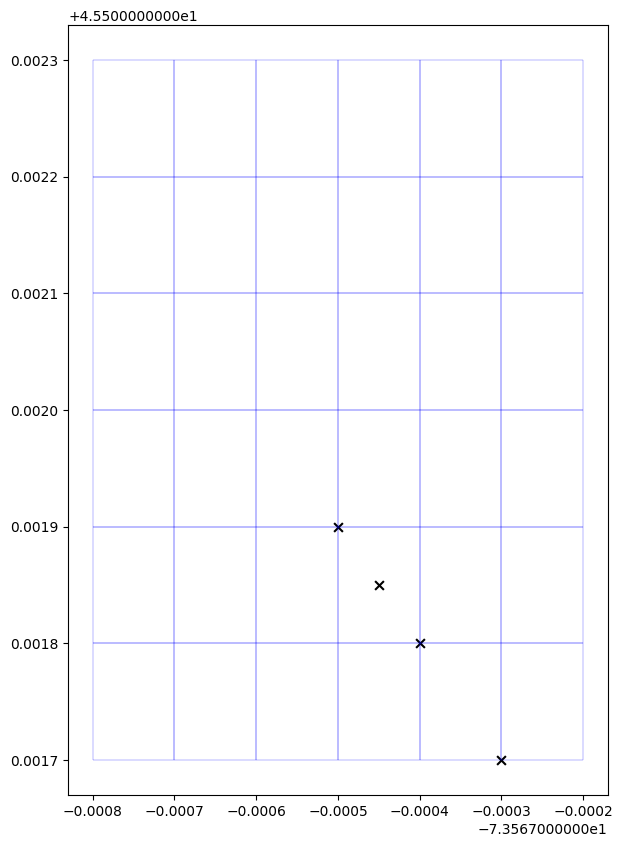

In [394]:
# Plot the result
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
squares_gdf.boundary.plot(ax=ax, color='blue', linewidth=0.2)
gdf1.plot(ax=ax, color='black', markersize=40, marker='x')
#gdf1_joined.plot(ax=ax, color='red', markersize=0.1, marker='o')
#gdf2.plot(ax=ax, color='blue', markersize=20, marker='x')
#gdf_joined.plot(ax=ax, color='green', markersize=30, marker='x')
plt.show()